In [1]:
import pandas as pd

In [4]:
merged_df = pd.read_csv('../data/curated/merged_df.csv')
merged_df_test = pd.read_csv('../data/curated/merged_df_test.csv')

In [5]:
merged_df['high_crime'] = merged_df['crime_count'].apply(lambda x: 1 if x > 300 else 0)
merged_df['high_tip_rate'] = merged_df['tip_rate'].apply(lambda x: 1 if x > 0.2 else 0)
merged_df['low_crime'] = merged_df['crime_count'].apply(lambda x: 1 if x < 300 else 0)
merged_df['low_tip_rate'] = merged_df['tip_rate'].apply(lambda x: 1 if x < 0.2 else 0)

merged_df_test['high_crime'] = merged_df_test['crime_count'].apply(lambda x: 1 if x > 300 else 0)
merged_df_test['high_tip_rate'] = merged_df_test['tip_rate'].apply(lambda x: 1 if x > 0.2 else 0)
merged_df_test['low_crime'] = merged_df_test['crime_count'].apply(lambda x: 1 if x < 300 else 0)merged_df_test['low_tip_rate'] = merged_df_test['tip_rate'].apply(lambda x: 1 if x < 0.2 else 0)

Mean Squared Error: 0.016239874170077485
Feature importances: [0.03930129 0.17301377 0.04445915 0.30969455 0.43353124]


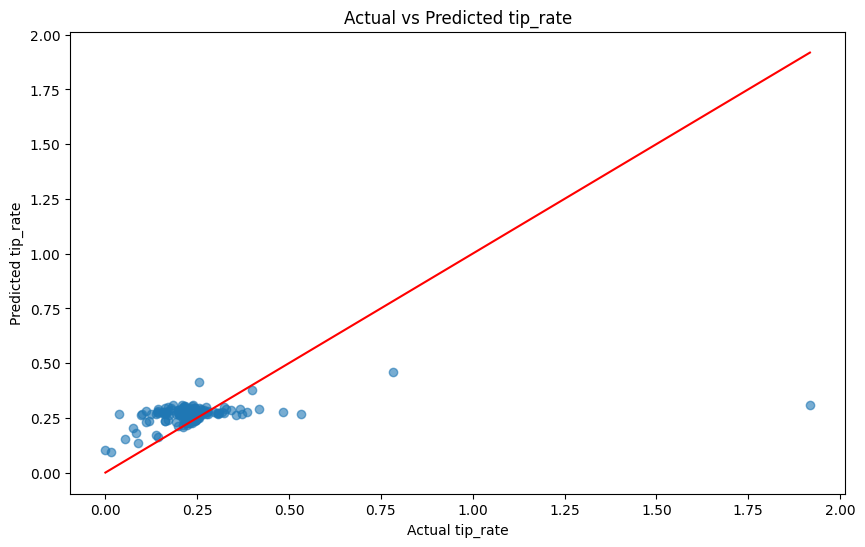

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 假设你的merged_df和merged_df_test数据已经被读取到两个DataFrame中

# 填充或处理缺失值

# 使用merged_df定义特征和目标变量进行训练
X_train = merged_df[['LocationID','average_time','crime_count','average_fare','average_tip']]
y_train = merged_df['tip_rate']

# 使用merged_df_test作为测试集
X_test = merged_df_test[['LocationID','average_time','crime_count','average_fare','average_tip']]
y_test = merged_df_test['tip_rate']

# 创建模型
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 使用全部merged_df数据训练模型
model.fit(X_train, y_train)

# 对merged_df_test进行预测
predictions = model.predict(X_test)

# 计算模型的MSE
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# 如果想查看特征的重要性
feature_importances = model.feature_importances_
print(f"Feature importances: {feature_importances}")

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.xlabel('Actual tip_rate')
plt.ylabel('Predicted tip_rate')
plt.title('Actual vs Predicted tip_rate')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # 红色线代表完美预测
plt.savefig('../plots/RF.png')
plt.show()


Accuracy using Gradient Boosting: 0.43478260869565216
              precision    recall  f1-score   support

   high_risk       0.14      0.83      0.24        23
    low_risk       0.93      0.70      0.80        37
not_worth_it       0.23      0.60      0.33         5
    worth_it       0.93      0.32      0.47       165

    accuracy                           0.43       230
   macro avg       0.56      0.61      0.46       230
weighted avg       0.83      0.43      0.50       230



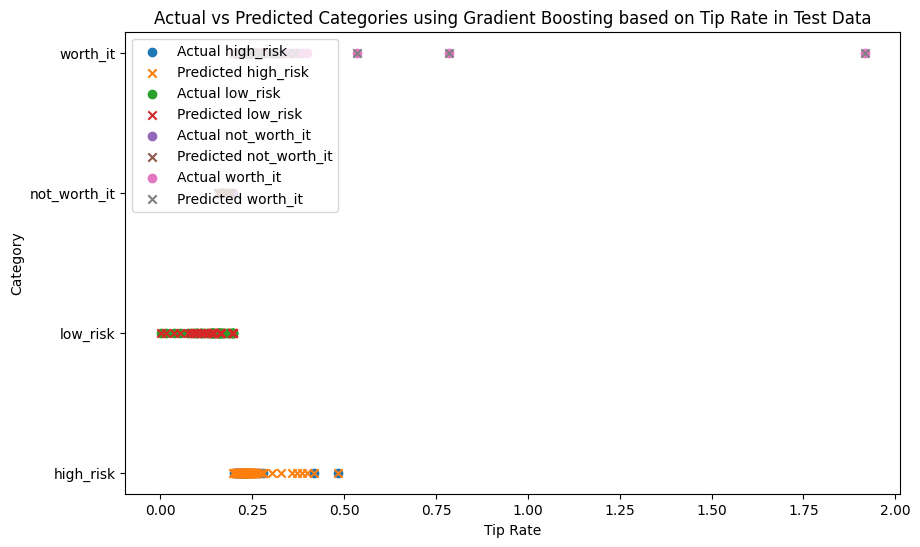

In [12]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# 生成新的目标变量
def create_target(row):
    if row['high_tip_rate'] == 1 and row['high_crime'] == 1:
        return 'high_risk'
    elif row['low_tip_rate'] == 1 and row['high_crime'] == 1:
        return 'not_worth_it'
    elif row['high_tip_rate'] == 1 and row['low_crime'] == 1:
        return 'worth_it'
    else:
        return 'low_risk'

# 为两个数据集生成目标变量
merged_df['target'] = merged_df.apply(create_target, axis=1)
merged_df_test['target'] = merged_df_test.apply(create_target, axis=1)

# 选择特征和新的目标
X_train = merged_df[['tip_rate']]
y_train = merged_df['target']

X_test = merged_df_test[['tip_rate']]
y_test = merged_df_test['target']

# 使用GradientBoostingClassifier训练模型
clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
clf_gb.fit(X_train, y_train)

# 对merged_df_test进行预测
y_pred_gb = clf_gb.predict(X_test)

# 计算准确率和其他指标
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy using Gradient Boosting: {accuracy_gb}")
print(classification_report(y_test, y_pred_gb))

# 绘制实际值与预测值的比较图
plt.figure(figsize=(10, 6))
unique_labels_gb = np.unique(y_test)
for label in unique_labels_gb:
    mask = y_test == label
    plt.scatter(X_test[mask]['tip_rate'], y_test[mask], label=f'Actual {label}')
    mask_pred = y_pred_gb == label
    plt.scatter(X_test[mask_pred]['tip_rate'], y_pred_gb[mask_pred], marker='x', label=f'Predicted {label}')

plt.legend(loc='upper left')
plt.xlabel('Tip Rate')
plt.ylabel('Category')
plt.title('Actual vs Predicted Categories using Gradient Boosting based on Tip Rate in Test Data')
plt.savefig('../plots/GB_1.png')
plt.show()


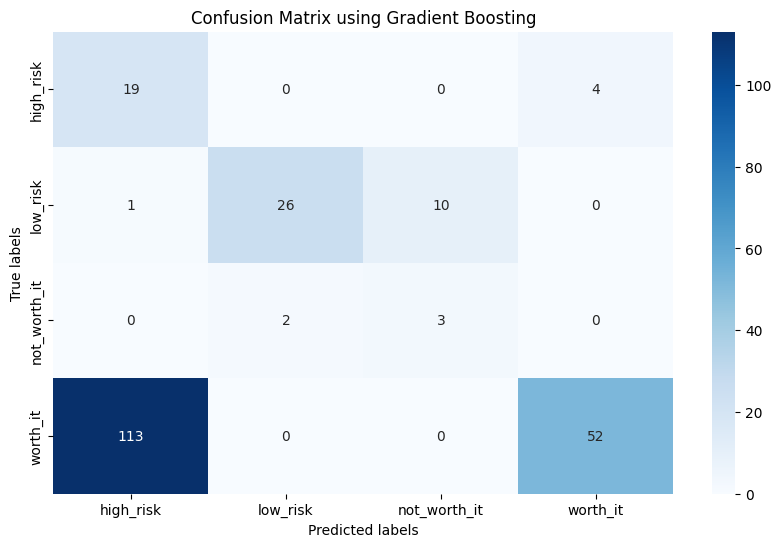

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 生成混淆矩阵
cm = confusion_matrix(y_test, y_pred_gb)
labels = unique_labels_gb

# 使用Seaborn的heatmap绘制混淆矩阵热力图
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix using Gradient Boosting')
plt.savefig('../plots/GB_2.png')
plt.show()
